In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy
import math

from evaluator import define_evaluator
from matplotlib import colors as plt_colors
from matplotlib import cm
import matplotlib as mpl

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['viridis']

In [2]:
evaluator = define_evaluator(
    run_script="run_spont_tuning.py",
    parameters_url="param_NESTML_tuning_spont/defaults",
    timeout = 2000
)

In [3]:
runs = []
for path in ["opt_check.pkl"]:
    with open(path, "rb") as checkpoint_file:
        run = pickle.load(checkpoint_file, encoding="latin1")
    runs.append(run)

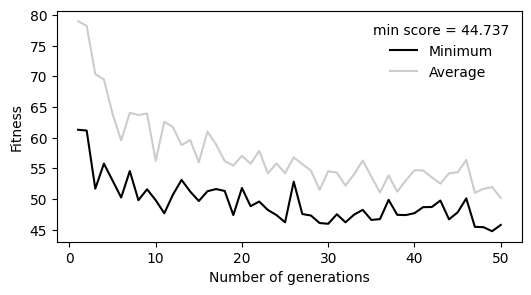

[61.287746793757705, 61.158969814797615, 51.68235602514034, 55.765251977109656, 53.008834986896275, 50.23043120838907, 54.55746745154222, 49.80180717812541, 51.57648196967945, 49.8048288696086, 47.6636823920049, 50.70304366502809, 53.108183432870646, 51.20967632495619, 49.66143937192871, 51.262698841366216, 51.61837873559904, 51.30526976193332, 47.37351622993032, 51.78836542585937, 48.818452462303014, 49.5831331960418, 48.206852048563576, 47.37500787636088, 46.187676630293296, 52.82481725647522, 47.54144584612328, 47.29752696902045, 46.07024446629873, 45.95417281480607, 47.50217667563966, 46.18735292115471, 47.44602406114194, 48.221784239027755, 46.57985771141401, 46.716646862793695, 49.851761597040635, 47.411159003796186, 47.36867902508575, 47.685517516585726, 48.66188079869437, 48.6845568289296, 49.74373965628618, 46.67889583872126, 47.812225331268, 50.09148071384932, 45.44804916437637, 45.395219514218255, 44.73660985376903, 45.764426708769676]


In [4]:
from scipy.optimize import curve_fit

fig, axs = plt.subplots(1, figsize=(6, 3), squeeze=False)

def exp_f(x, a, b, c):
    return a * numpy.exp(-x / b) + c

for run in runs:

    ngen = run["logbook"].select("gen")

    axs[0, 0].plot(ngen, run["logbook"].select("min"), label="Minimum", c="black")
    axs[0, 0].plot(ngen, run["logbook"].select("avg"), label="Average", c="gray", alpha=0.4)

    axs[0, 0].set_xlabel("Number of generations")
    axs[0, 0].set_ylabel("Fitness")

    legend_text = "\n".join(
        (
            f"min score = {min(run['logbook'].select('min')):.3f}",
        )
    )

    axs[0, 0].legend(title=legend_text, loc="upper right", frameon=False)

plt.show()
print(run["logbook"].select("min"))

In [5]:
published_params = [
    0.00018, 0.00022, 0.0012, # L4 Exc
    0.001, 0.001, 0.0012, # L4 Inh
    0.00018, 0.00035, 0.001, 0.00018, 0.00022, # L23 Exc
    0.0009, 0.0009, 0.001 # L23 Inh
]

for run in runs:
    print()
    print("Sigma: ", run["CMA_es"].sigma)
    print("Best model:")
    print("{")
    for p, v in zip(evaluator.param_names, run["halloffame"][0]):
        print(f'    "{p}": [{round(v, 8)}],')
    print("}")

    print("Changes compared to base model:")
    for p, v, pp in zip(evaluator.param_names, run["halloffame"][0], published_params):
        diff = 100 * (v - pp) / pp
        if diff > 0:
            sign = "+"
        else:
            sign = ""
        print(f"  {p} {round(pp, 8)} -> {round(v, 8)} ({sign}{round(diff, 2)}%)")

print(run["halloffame"][0])


Sigma:  0.11234615106369424
Best model:
{
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00017718],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00023881],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00216575],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.0013557],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.00213692],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.0029992],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [9.51e-05],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00036459],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.0014],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00024304],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00025825],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.0020091],
    "sheets.l23_cortex_inh.L23InhL23InhConnection.base_

In [6]:
from scipy.stats import pearsonr

n_params = len(run["halloffame"][0])
n_targets = len(run["halloffame"][0].fitness.values)

corrs = []
for idx_param in range(n_params):
    for idx_targets in range(n_targets):

        X = []
        Y = []
        for idx_pop in run['history'].genealogy_history:

            ind = run['history'].genealogy_history[idx_pop]
            scores = numpy.array([float(v) for v in ind.fitness.values])
            X.append(ind[idx_param])
            Y.append(scores[idx_targets])

        corrs.append(pearsonr(X, Y)[0])

    
        """if abs(corrs[-1]) > 0.5:
            fig, ax = plt.subplots(1, figsize=(3, 3))
            ax.scatter(X, Y)
            ax.set_xlabel(f"{evaluator.param_names[idx_param].replace('_cortex_', ' ' ).replace('sheets.', '').replace('.base_weight', '')}")
            ax.set_ylabel(f"{evaluator.fitness_calculator.objectives[idx_targets].name.replace('_V1_', '')}")
            plt.show()"""

corrs = numpy.array(corrs).reshape(n_params, n_targets)

0.0008594646496530459 0.7506618111386455


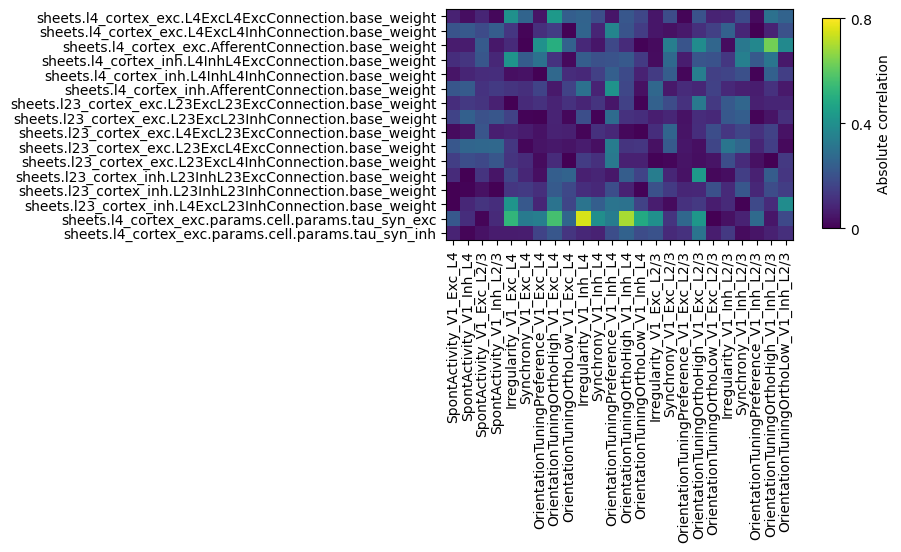

In [7]:
# This is an approximation since the other parameters are not fix
# WARNING THIS IS THE CORRELATION WITH THE SCORES OF THE TARGET NOT WITH THE VALUE OF THE TARGET.

fig, ax = plt.subplots(1, figsize=(6, 3))

ax.imshow(numpy.abs(corrs), vmin=0, vmax=0.8)
print(numpy.min(numpy.abs(corrs)), numpy.max(numpy.abs(corrs)))

ax.set_xticks(range(n_targets))
scores_names = [target.name for target in evaluator.fitness_calculator.objectives]
ax.set_xticklabels(scores_names, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels([pn for pn in evaluator.param_names])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
norm = mpl.colors.Normalize(vmin=0, vmax=0.8)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax, orientation='vertical', label='Absolute correlation'
)
cbar.ax.set_yticks([0, 0.4, 0.8])
cbar.ax.set_yticklabels([0, 0.4, 0.8])

plt.show()

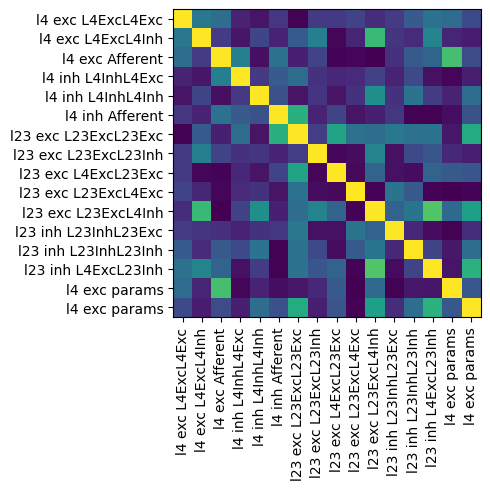

In [8]:
fig, ax = plt.subplots(1, figsize=(4, 4))

ax.imshow(numpy.abs(run["CMA_es"].C), vmin=0, vmax=0.3)

ax.set_xticks(range(n_params))
shorten = [pn.split(".")[1].replace("_cortex_", " ") + " " + pn.split(".")[2].replace("Connection", "") for pn in evaluator.param_names]
ax.set_xticklabels(shorten, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels(shorten)

plt.show()

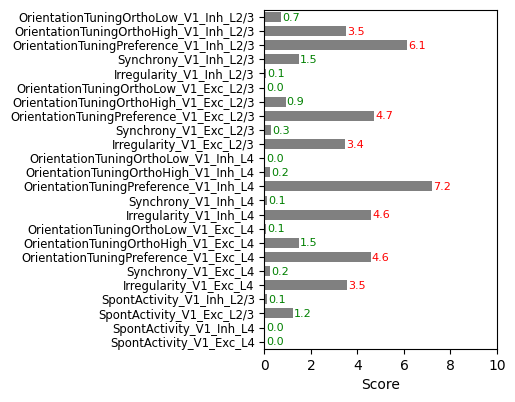

In [9]:
for run in runs:

    score = [float(f) for f in run["halloffame"][0].fitness.values]
    scores_names = [target.name for target in evaluator.fitness_calculator.objectives]

    pos = [*range(len(score))]
    
    fig, axs = plt.subplots(1, figsize=(3, 0.8 + 0.150 * len(pos)), squeeze=False)

    axs[0, 0].barh(pos, score, height=0.7, align="center", color="gray")

    for p, s in zip(pos, score):
        if s > 2:
            axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="red", fontsize=8)
        if s < 2:
            axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="green", fontsize=8)

    axs[0, 0].set_xlabel("Score")

    axs[0, 0].set_yticks(pos)
    axs[0, 0].set_yticklabels(scores_names, size="small")

    axs[0, 0].set_xlim(0, 10)
    axs[0, 0].set_ylim(-0.5, len(pos) - 0.5)

    plt.show()

/tmp/ipykernel_1511423/3666971644.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


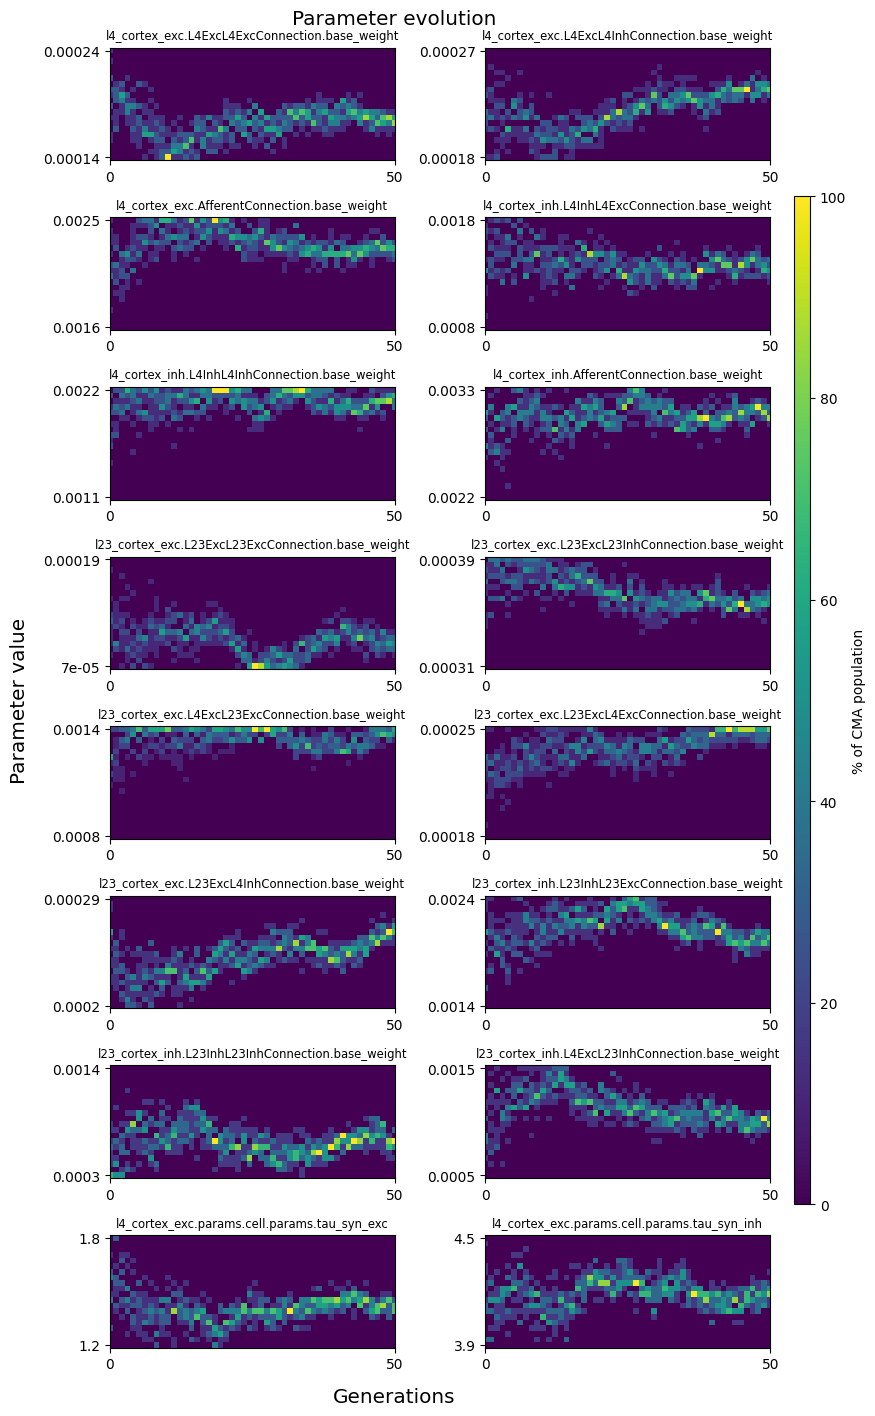

In [10]:
for run in runs:

    max_n_gen = run["generation"]
    gen_per_bin = 1
    pop_size = len(run["population"])
    histo_bins = (int(max_n_gen / gen_per_bin), 20)
    normalization_factor = gen_per_bin * pop_size

    # Get the histograms for all parameters
    histograms = {}
    for param_index in range(len(run["history"].genealogy_history[1])):
        x = [(ind_idx - 1) // pop_size for ind_idx in run["history"].genealogy_history.keys()]
        y = [ind[param_index] for ind in run["history"].genealogy_history.values()]

        histo_range = [
            [0, max_n_gen],
            [
                evaluator.params[param_index].bounds[0],
                evaluator.params[param_index].bounds[1],
            ],
        ]

        h, _, _ = numpy.histogram2d(x, y, bins=histo_bins, range=histo_range)
        normalized_h = h / normalization_factor

        histograms[param_index] = normalized_h

    ncols = 2
    nrows = math.ceil(len(evaluator.params) / ncols)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 1.8 * nrows))
    axs = axs.flat

    # Plot the histograms
    for param_index, param in enumerate(evaluator.params):
        axs[param_index].imshow(
            100.0 * numpy.flip(histograms[param_index].T, 0),
            aspect="auto",
            interpolation="none",
        )

        axs[param_index].set_title(list(evaluator.param_names)[param_index].replace("sheets.", ""), size="small")

        x_ticks_pos = [0, int(max_n_gen / gen_per_bin) - 1]
        x_ticks_label = [0, int(max_n_gen / gen_per_bin) * gen_per_bin]
        axs[param_index].set_xticks(x_ticks_pos, x_ticks_label)
        axs[param_index].set_yticks([0, 19], [param.bounds[1], param.bounds[0]])
        axs[param_index].set_xlim(0, int(max_n_gen / gen_per_bin) - 1)

    for axs_index in range(len(evaluator.params), len(axs)):
        axs[axs_index].set_visible(False)

    # Add a colorbar common to all subplots
    norm = plt_colors.Normalize(vmin=0, vmax=100, clip=False)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax, label="% of CMA population",)

    fig.supxlabel("Generations", size="x-large")
    fig.supylabel("Parameter value", size="x-large")

    suptitle = "Parameter evolution"
    fig.suptitle(suptitle, size="x-large")

    plt.tight_layout()

    plt.show()